In [228]:
import numpy as np
from data_generation.helper import load_phantom
import matplotlib.pyplot as plt
import imageio.v2 as iio
import os
from src.MSDNNet import MSDNet
import torch

import matplotlib
from matplotlib import lines

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.cbook import get_sample_data
import astra

matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [215]:
def run_algorithm(image_id, sinogram_id,
                    projector_id, algorithm='FBP',
                    num_iterations=100):
    
    # Set up
    cfg = astra.astra_dict(algorithm)
    cfg['ProjectorId'] = projector_id
    cfg['ProjectionDataId'] = sinogram_id
    image_id_str = 'VolumeDataId' if algorithm == 'FP' else 'ReconstructionDataId'
    cfg[image_id_str] = image_id
    if algorithm == 'SIRT':
        cfg['option'] = {'MinConstraint': 0, 'MaxConstraint': 1}
    # Run the algorithm
    alg_id = astra.algorithm.create(cfg)
    astra.algorithm.run(alg_id, num_iterations)
    # Clean up
    astra.algorithm.delete(alg_id)

    return astra.data2d.get(image_id) 


def reconstruct(image, num_angles,
                from_sinogram=False,
                num_iterations=100):
    angles = np.linspace(0, num_angles, image.shape[0], False)
    proj_geom = astra.create_proj_geom('parallel', 1.0, image.shape[1], angles)
    
    vol_geom = astra.create_vol_geom(image.shape)
    projector_id = astra.create_projector('linear', proj_geom, vol_geom)
    recon_id = astra.data2d.create('-vol', vol_geom, data=image)

    if from_sinogram: # Assume image is sinogram
        sinogram = image.copy()
        sinogram_id = astra.data2d.create('-sino', proj_geom, sinogram)

    else: # Include sinogram creation
        sinogram_id = astra.data2d.create('-sino', proj_geom)
        _ = run_algorithm(recon_id, sinogram_id, projector_id,
                          'FP', num_iterations)
        sinogram = astra.data2d.get(sinogram_id)

    # SIRT
    sirt_recon = run_algorithm(recon_id, sinogram_id, projector_id, 
                               'SIRT', num_iterations)

    # Clean-up
    astra.projector.delete(projector_id)
    astra.data2d.delete(recon_id)
    astra.data2d.delete(sinogram_id)
    
    return sirt_recon

def plot_zoomed(ax, img, zoom=3, limits=(69, 99, 60, 90),
                extent=(0, 255, 0, 255), loc1=2, loc2=4):
    ax.imshow(img, extent=extent, cmap='gray', origin='lower')
    axins = zoomed_inset_axes(ax, zoom=zoom, loc=1)
    axins.set_xlim(limits[0], limits[1])
    axins.set_ylim(limits[2], limits[3])
    axins.imshow(img, extent=extent, cmap='gray', origin='lower')
    axins.axes.get_yaxis().set_visible(False)
    axins.axes.get_xaxis().set_visible(False)
    for spine in axins.spines.values():
            spine.set_edgecolor('r')
    mark_inset(ax, axins, loc1=loc1, loc2=loc2, fc="none", ec="r")
    return axins

In [ ]:
data_folder = '3d_data'
dt = 'noisy'
idx = np.random.randint(0, 129)
fig, axs = plt.subplots(7, 5, figsize=(10, 12))

for i in range(len(axs[0])):
    slice = iio.imread(f'{data_folder}/phantoms/train/45/{dt}/{i}.tiff')
    axs[0][i].imshow(slice, origin='lower', cmap='grey')
    for j, angle in enumerate((45, 90, 180)):
        sinogram = iio.imread(f'{data_folder}/sinograms/train/{angle}/{dt}/{i}.tiff')
        axs[j+1][i].imshow(sinogram, origin='lower', cmap='grey')

    for j, angle in enumerate((45, 90, 180)):
        fbp = iio.imread(f'{data_folder}/fbps/train/{angle}/{dt}/{i}.tiff')
        axs[j+4][i].imshow(fbp, origin='lower', cmap='grey')
        
axs = axs.flatten()
[ax.axis('off') for ax in axs]
plt.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(10, 10, figsize=(28, 28))
axs = axs.flatten()
for i in range(100):
    img = iio.imread(f'3d_data/sinograms/train/45/clean/{i}.tiff')
    axs[i].imshow(img, cmap='grey', origin='lower')
    axs[i].set_title(f'{i}')
    axs[i].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
phantom = iio.imread('phantom/test/clean/45/3.tiff')
sirt = reconstruct(phantom, 45)
phantom3d = iio.imread('3d_data/phantom/test/45/clean/100.tiff')
sirt3d = reconstruct(phantom3d, 45)

/var/folders/j8/xlfl488j7csblljxvg0xx4nh0000gn/T/ipykernel_37384/1024321516.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


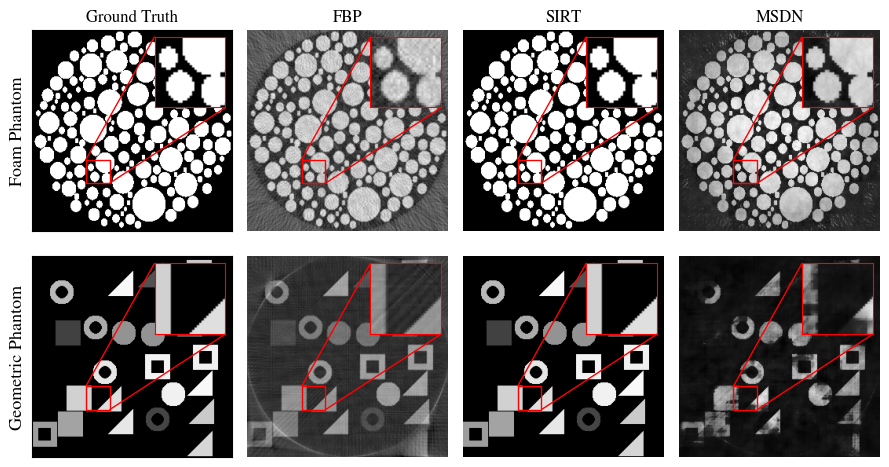

In [136]:
fig, axs = plt.subplots(2, 4, figsize=(9, 5))
axs = axs.flatten()
extent = (0,255,0,255)
root = '3d_data'
i = 3
eval_dir3d = 'evaluations/model3d_240607201524'
eval_dir = 'evaluations/model2_240607180032'
input3d = iio.imread(f'{eval_dir3d}/input_{i}.tiff')
output3d = iio.imread(f'{eval_dir3d}/output_{i}.tiff')
input = iio.imread(f'{eval_dir}/input_{i}.tiff')
output = iio.imread(f'{eval_dir}/output_{i}.tiff')
plot_zoomed(axs[0], phantom3d)
plot_zoomed(axs[1], input3d)
plot_zoomed(axs[2], sirt3d)
plot_zoomed(axs[3], output3d)
plot_zoomed(axs[4], phantom)
plot_zoomed(axs[5], input)
plot_zoomed(axs[6], sirt)
plot_zoomed(axs[7], output)
[ax.axis('off') for ax in axs]
axs[0].axis('on')
axs[4].axis('on')
axs[0].tick_params(axis=u'both', which=u'both',length=0)
axs[4].tick_params(axis=u'both', which=u'both',length=0)
plt.setp(axs[0].get_xticklabels(), visible=False)
plt.setp(axs[0].get_yticklabels(), visible=False)
plt.setp(axs[4].get_xticklabels(), visible=False)
plt.setp(axs[4].get_yticklabels(), visible=False)
axs[0].set_title('Ground Truth')
axs[1].set_title('FBP')
axs[2].set_title('SIRT')
axs[3].set_title('MSDN')
axs[0].set_ylabel('Foam Phantom', fontsize=13)
axs[4].set_ylabel('Geometric Phantom', fontsize=13)
plt.tight_layout()
plt.show()

In [205]:
root_folder = '3d_data'
model_fn = 'model3d.pth'
print('Loading model.')
model = MSDNet(in_channels=4, out_channels=4, num_features=4, 
                num_layers=100,  dilations=np.arange(1, 101))
model.load_state_dict(torch.load(model_fn, map_location=torch.device('cpu')))

phantom_3d = iio.imread(f'{root_folder}/phantom/test/180/clean/0.tiff')
fbps = {ang: iio.imread(f'{root_folder}/recon/test/{ang}/clean/0.tiff')
        for ang in (45, 90, 180)}

s = (1, 256, 256)
batch = np.concatenate([fbps[45].reshape(s), fbps[90].reshape(s),
                        fbps[180].reshape(s), fbps[180].reshape(s)])
batch = torch.Tensor(batch)
outputs = model(batch).detach().numpy()[:3]
msdns = {45: outputs[0], 90: outputs[1], 180: outputs[2]}


Loading model.


In [246]:
root_folder = '.'
model_fn = 'model180.pth'
print('Loading model.')
model_geo = MSDNet(in_channels=4, out_channels=4, num_features=4, 
                num_layers=100,  dilations=np.arange(1, 101))
model_geo.load_state_dict(torch.load(model_fn, map_location=torch.device('cpu')))

phantom_geo = iio.imread(f'{root_folder}/phantom/test/clean/180/0.tiff')
fbps_geo = {ang: iio.imread(f'{root_folder}/recon/test/clean/{ang}/0.tiff')
        for ang in (45, 90, 180)}

s = (1, 256, 256)
batch = np.concatenate([fbps_geo[45].reshape(s), fbps_geo[90].reshape(s),
                        fbps_geo[180].reshape(s), fbps_geo[180].reshape(s)])
batch_geo = torch.Tensor(batch)
outputs_geo = model_geo(batch_geo).detach().numpy()[:3]
msdns_geo = {45: outputs_geo[0], 90: outputs_geo[1], 180: outputs_geo[2]}

Loading model.


/var/folders/j8/xlfl488j7csblljxvg0xx4nh0000gn/T/ipykernel_37384/1772241211.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


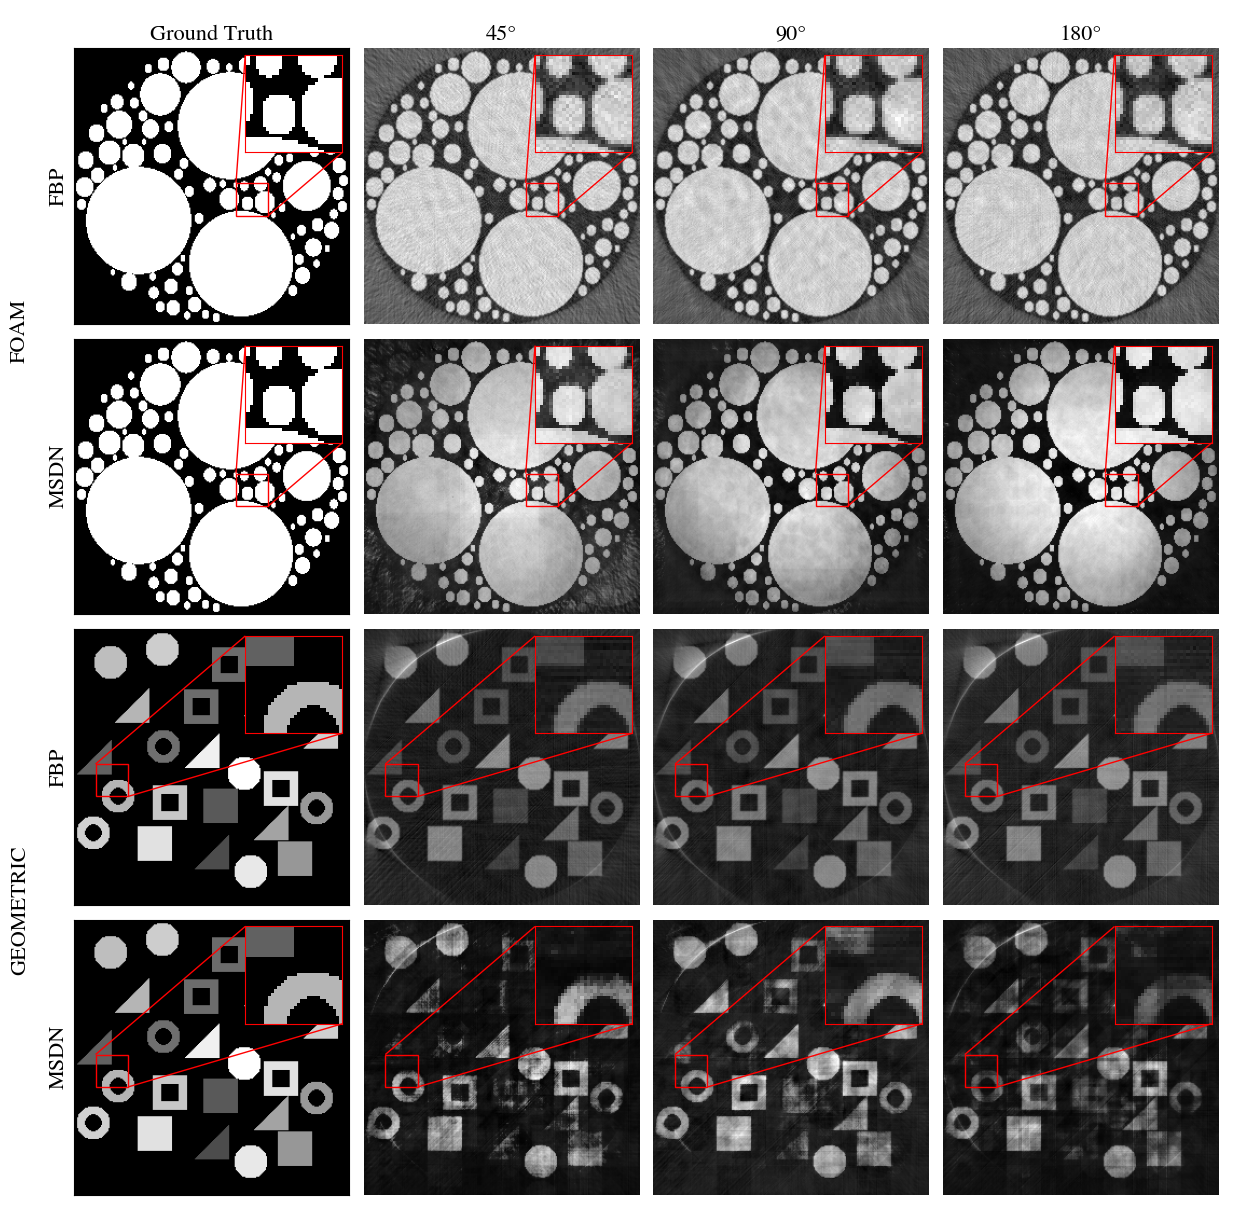

In [247]:
fig, axs = plt.subplots(4, 4, figsize=(12, 12))

x, x1 = 150, 20
y, y1 = 100, 100
args = {'limits': (x, x+30, y, y+30)}
args2 = {'limits': (x1, x1+30, y1, y1+30)}
axs = axs.flatten()


plot_zoomed(axs[0], phantom_3d, **args)
plot_zoomed(axs[1], fbps[45], **args)
plot_zoomed(axs[2], fbps[90], **args)
plot_zoomed(axs[3], fbps[180], **args)
plot_zoomed(axs[4], phantom_3d, **args)
plot_zoomed(axs[5], msdns[45], **args)
plot_zoomed(axs[6], msdns[90], **args)
plot_zoomed(axs[7], msdns[180], **args)
plot_zoomed(axs[8], phantom_geo, **args2)
plot_zoomed(axs[9], fbps_geo[45], **args2)
plot_zoomed(axs[10], fbps_geo[90], **args2)
plot_zoomed(axs[11], fbps_geo[180], **args2)
plot_zoomed(axs[12], phantom_geo, **args2)
plot_zoomed(axs[13], msdns_geo[45], **args2)
plot_zoomed(axs[14], msdns_geo[90], **args2)
plot_zoomed(axs[15], msdns_geo[180], **args2)

ax0 = plt.axes([0, 0, 1, 1])
ax0.axis('off')
ax0.text(-0.02, 0.71, "FOAM", rotation=90, fontsize=16)
ax0.text(-0.02, 0.2, "GEOMETRIC", rotation=90, fontsize=16)

axs[0].set_title('Ground Truth', fontsize=16)
axs[1].set_title('45°', fontsize=16)
axs[2].set_title('90°', fontsize=16)
axs[3].set_title('180°', fontsize=16)
axs[0].set_ylabel('FBP', fontsize=16)
axs[4].set_ylabel('MSDN', fontsize=16)
axs[8].set_ylabel('FBP', fontsize=16)
axs[12].set_ylabel('MSDN', fontsize=16)

[ax.axis('off') for ax in axs]
for idx in (0, 4, 8, 12):
    axs[idx].axis('on')
    axs[idx].tick_params(axis=u'both', which=u'both',length=0)
    plt.setp(axs[idx].get_xticklabels(), visible=False)
    plt.setp(axs[idx].get_yticklabels(), visible=False)
plt.tight_layout()
plt.show()

## CLEAN v. NOISY

In [257]:
root_folder = '.'
phantom_geo_clean = iio.imread(f'{root_folder}/phantom/test/clean/180/0.tiff')
phantom_geo_noisy = iio.imread(f'{root_folder}/phantom/test/noisy/180/0.tiff')

fbps_geo = {group: iio.imread(f'{root_folder}/recon/test/{group}/180/0.tiff')
        for group in ('clean', 'noisy')}

s = (1, 256, 256)
batch = np.concatenate([fbps_geo['clean'].reshape(s), fbps_geo['noisy'].reshape(s),
                        fbps_geo['clean'].reshape(s), fbps_geo['noisy'].reshape(s)])
batch_geo = torch.Tensor(batch)
outputs_geo = model_geo(batch_geo).detach().numpy()[:2]
msdns_geo = {'clean': outputs_geo[0], 'noisy': outputs_geo[1]}

In [255]:
root_folder = '3d_data'
phantom_foam_clean = iio.imread(f'{root_folder}/phantom/test/180/clean/0.tiff')
phantom_foam_noisy = iio.imread(f'{root_folder}/phantom/test/180/noisy/0.tiff')

fbps = {group: iio.imread(f'{root_folder}/recon/test/180/{group}/0.tiff')
        for group in ('clean', 'noisy')}

s = (1, 256, 256)
batch = np.concatenate([fbps['clean'].reshape(s), fbps['noisy'].reshape(s),
                        fbps['clean'].reshape(s), fbps['noisy'].reshape(s)])
batch = torch.Tensor(batch)
outputs = model(batch).detach().numpy()[:3]
msdns = {'clean': outputs[0], 'noisy': outputs[1]}

/var/folders/j8/xlfl488j7csblljxvg0xx4nh0000gn/T/ipykernel_37384/4257611312.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


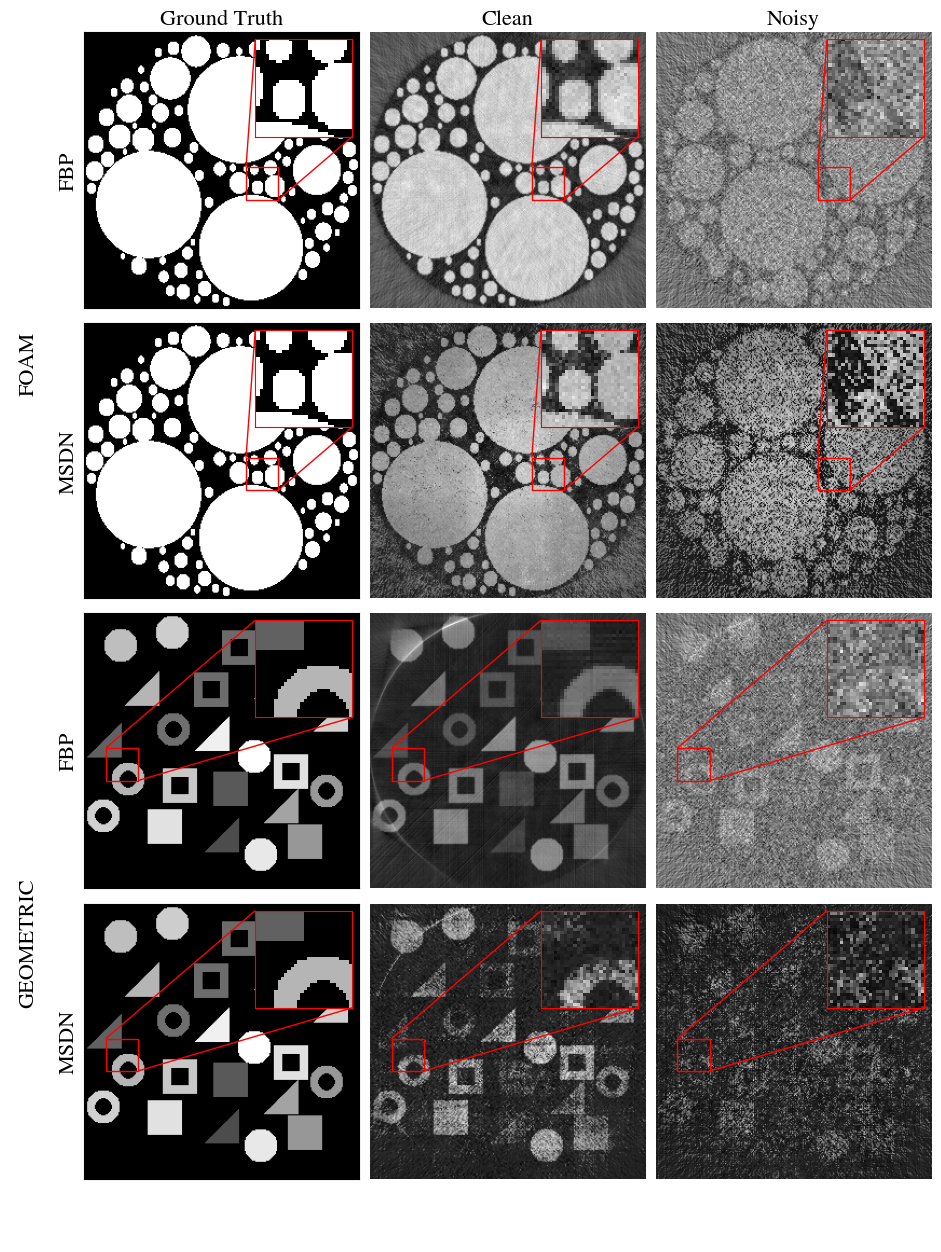

In [268]:
fig, axs = plt.subplots(4, 3, figsize=(9, 12))

x, x1 = 150, 20
y, y1 = 100, 100
args = {'limits': (x, x+30, y, y+30)}
args2 = {'limits': (x1, x1+30, y1, y1+30)}
axs = axs.flatten()


plot_zoomed(axs[0], phantom_3d, **args)
plot_zoomed(axs[1], fbps['clean'], **args)
plot_zoomed(axs[2], fbps['noisy'], **args)
plot_zoomed(axs[3], phantom_3d, **args)
plot_zoomed(axs[4], msdns['clean'], **args)
plot_zoomed(axs[5], msdns['noisy'], **args)
plot_zoomed(axs[6], phantom_geo, **args2)
plot_zoomed(axs[7], fbps_geo['clean'], **args2)
plot_zoomed(axs[8], fbps_geo['noisy'], **args2)
plot_zoomed(axs[9], phantom_geo, **args2)
plot_zoomed(axs[10], msdns_geo['clean'], **args2)
plot_zoomed(axs[11], msdns_geo['noisy'], **args2)

ax0 = plt.axes([-0.04, -0.04, 1, 1])
ax0.axis('off')
ax0.text(0.01, 0.71, "FOAM", rotation=90, fontsize=16)
ax0.text(0.01, 0.2, "GEOMETRIC", rotation=90, fontsize=16)


axs[0].set_title('Ground Truth', fontsize=16)
axs[1].set_title('Clean', fontsize=16)
axs[2].set_title('Noisy', fontsize=16)
axs[0].set_ylabel('FBP', fontsize=16)
axs[3].set_ylabel('MSDN', fontsize=16)
axs[6].set_ylabel('FBP', fontsize=16)
axs[9].set_ylabel('MSDN', fontsize=16)

[ax.axis('off') for ax in axs]
for idx in (0, 3, 6, 9):
    axs[idx].axis('on')
    axs[idx].tick_params(axis=u'both', which=u'both',length=0)
    plt.setp(axs[idx].get_xticklabels(), visible=False)
    plt.setp(axs[idx].get_yticklabels(), visible=False)
plt.tight_layout()
plt.show()